## Computation of Lattices $\mathcal{L}$ and $\mathcal{L}_0$

In [1]:
from math import gcd
import matplotlib.pyplot as plt
import numpy as np

def mod_inverse(a, n):
    """
    Calculate the modular inverse of 'a' modulo 'n' using the extended Euclidean algorithm.
    Returns None if the inverse does not exist.
    """
    t, new_t = 0, 1
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None  # a isn't invertible modulo n
    if t < 0:
        t += n
    return t

def mod_exp(base, exp, mod):
    """
    Calculate base^exp modulo mod, handling negative exponents.
    """
    if exp >= 0:
        return pow(base, exp, mod)
    else:
        inv = mod_inverse(base, mod)
        if inv is None:
            raise ValueError(f"the modular inverse of {base} modulo {mod} doesnt' exist.")
        return pow(inv, -exp, mod)

def is_in_L(z1, z2, a1, a2, N):
    """
    Check wether (z1,z2) is in L by testing a1^z1 * a2^z2 ≡ 1 mod N.
    """
    try:
        val = (mod_exp(a1, z1, N) * mod_exp(a2, z2, N)) % N
        return val == 1
    except ValueError:
        return False

def is_in_L0(z1, z2, b1, b2, N):
    """
    Check wether (z1,z2) is in L0 by testing  b1^z1 * b2^z2 ≡ ±1 mod N. 
    """
    try:
        val = (mod_exp(b1, z1, N) * mod_exp(b2, z2, N)) % N
        return val == 1 or val == N - 1
    except ValueError:
        return False
    
    
def compute_lattice_basis(L):
    """
    Computes a basis of the lattice L from the list of its vectors.

    Args:
        L (list): List of vectors of the lattice L.

    Returns:
        list: List of basis vectors of L.
    """
    # Convert L into a set to remove duplicates
    L_set = set(L)

    # Remove the zero vector if it is present
    L_set.discard((0, 0))

    # Convert to a list and sort by increasing norm
    L_list = sorted(L_set, key=lambda v: v[0]**2 + v[1]**2)

    # Search for two linearly independent vectors
    for i in range(len(L_list)):
        v1 = np.array(L_list[i])
        for j in range(i + 1, len(L_list)):
            v2 = np.array(L_list[j])
            # Compute the determinant to check linear independence
            det = v1[0] * v2[1] - v1[1] * v2[0]
            if det != 0:
                return [v1, v2]

    # If unable to find two independent vectors, return what we have
    if L_list:
        return [np.array(L_list[0])]
    else:
        return []


def find_lattices(N, b1, b2, z_range=5):
    """
    Finds the lattices L and L0 for N, b1, b2.

    Args:
        N (int): The number for which we are searching the lattices.
        b1 (int): First prime number.
        b2 (int): Second prime number.
        z_range (int): Maximum absolute value for the exponents z1 and z2.

    Returns:
        dict: Contains the lattices L, L0, L \ L0, the factors found, and the basis of L.
    """
    a1 = pow(b1, 2, N)
    a2 = pow(b2, 2, N)

    lattice_L = []
    lattice_L0 = []

    for z1 in range(-z_range, z_range + 1):
        for z2 in range(-z_range, z_range + 1):
            if is_in_L(z1, z2, a1, a2, N):
                lattice_L.append((z1, z2))
                if is_in_L0(z1, z2, b1, b2, N):
                    lattice_L0.append((z1, z2))

    # Compute L \ L0
    lattice_diff = [vec for vec in lattice_L if vec not in lattice_L0]

    # Compute the basis of L using all points of L
    basis_L = compute_lattice_basis(lattice_L)

    # Attempt to factorize N using L \ L0
    factors = set()
    for z1, z2 in lattice_diff:
        try:
            b = (mod_exp(b1, z1, N) * mod_exp(b2, z2, N)) % N
            d1 = gcd(b - 1, N)
            d2 = gcd(b + 1, N)
            if 1 < d1 < N:
                factors.add(d1)
            if 1 < d2 < N:
                factors.add(d2)
        except ValueError:
            continue  # Modular inverse does not exist, move to the next vector

    return {
        "L": lattice_L,
        "L0": lattice_L0,
        "L \\ L0": lattice_diff,
        "factors": list(factors),
        "basis_L": basis_L
    }


def plot_lattices(L, L0):
    """
    Plots the points of lattice L and sublattice L0.
    Points of L are in blue, and those of L0 are in red.
    """
    # Separate coordinates for L
    z1_L = [vec[0] for vec in L]
    z2_L = [vec[1] for vec in L]

    # Separate coordinates for L0
    z1_L0 = [vec[0] for vec in L0]
    z2_L0 = [vec[1] for vec in L0]

    plt.figure(figsize=(8, 8))
    plt.scatter(z1_L, z2_L, color='blue', label='Lattice L')
    plt.scatter(z1_L0, z2_L0, color='red', label='Sublattice L0')

    # Add axes and grid
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set axis limits
    all_z1 = z1_L + z1_L0
    all_z2 = z2_L + z2_L0
    max_range = max(max(map(abs, all_z1)), max(map(abs, all_z2))) + 1
    plt.xlim(-max_range, max_range)
    plt.ylim(-max_range, max_range)

    # Configure axis ticks to display only integers
    x_ticks = range(-max_range, max_range + 1)
    y_ticks = range(-max_range, max_range + 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Lattice L and Sublattice L0')
    plt.legend()
    plt.show()



## Dual Lattice $\mathcal{L}^*$ (find basis +plot)

In [3]:
def compute_dual_lattice_from_basis(basis_vectors):
    """
    Computes the dual of the lattice L from the basis vectors.

    Args:
        basis_vectors (list): List of basis vectors of the lattice L.

    Returns:
        numpy.ndarray: Matrix containing the basis vectors of the dual of L.
    """
    
    B = np.column_stack(basis_vectors)  # Each column is a basis vector

    
    try:
        B_inv_T = np.linalg.inv(B).T
    except np.linalg.LinAlgError:
        print("The basis matrix is singular, unable to compute the dual.")
        return None

    return B_inv_T


def plot_dual_lattice(dual_basis, xlim=(-1, 1), ylim=(-1, 1), fig_name =""):
    """
    Plots the dual lattice L* on a separate graph with specified axis limits.

    Args:
        dual_basis (numpy.ndarray): Matrix containing the basis vectors of the dual of L.
        xlim (tuple): Limits of the x-axis in the form (xmin, xmax).
        ylim (tuple): Limits of the y-axis in the form (ymin, ymax).
    """
    if dual_basis is None:
        print("The dual lattice cannot be plotted because the dual basis is invalid.")
        return

    
    m_range = n_range = range(-10, 11)  

    dual_points = []
    for m in m_range:
        for n in n_range:
            point = m * dual_basis[:, 0]
            if dual_basis.shape[1] > 1:
                point += n * dual_basis[:, 1]
            x, y = point
            if xlim[0] - 1 <= x <= xlim[1] + 1 and ylim[0] - 1 <= y <= ylim[1] + 1:
                dual_points.append(point)

    # Separate coordinates for L*
    z1_dual = [point[0] for point in dual_points]
    z2_dual = [point[1] for point in dual_points]

    plt.figure(figsize=(8,8))

    # Plot the points of L*
    plt.scatter(z1_dual, z2_dual, color='black', label='Dual Lattice L*')

    # Add axes and grid
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Dual Lattice L*')
    plt.legend()
    if fig_name!=0:
        plt.savefig(fig_name)
    plt.show()


# Examples

## N=15, b_i=2,7

Basis of the lattice L:
[-1 -1]
[ 1 -1]

Non trivial factor of N:
[3, 5]

Basis of the dual lattice of L:
[[-0.5  0.5]
 [-0.5 -0.5]]


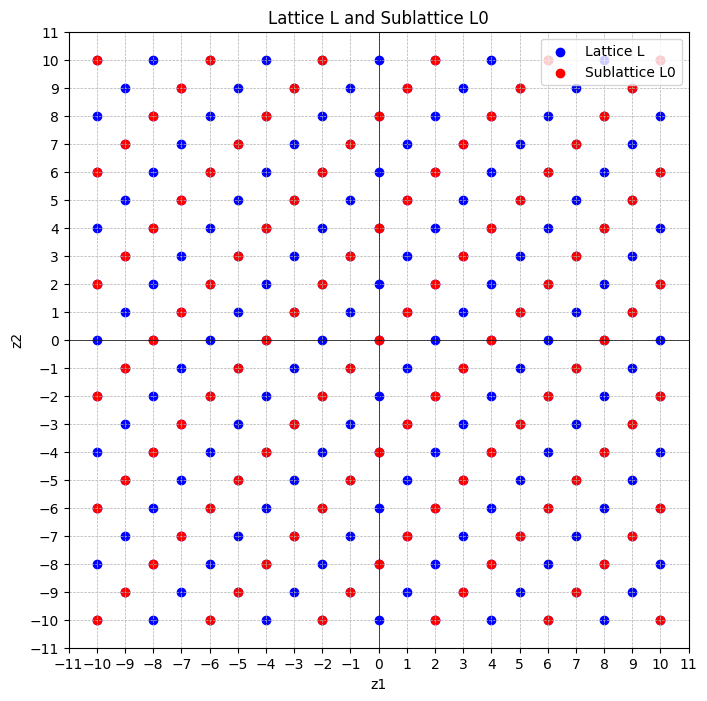

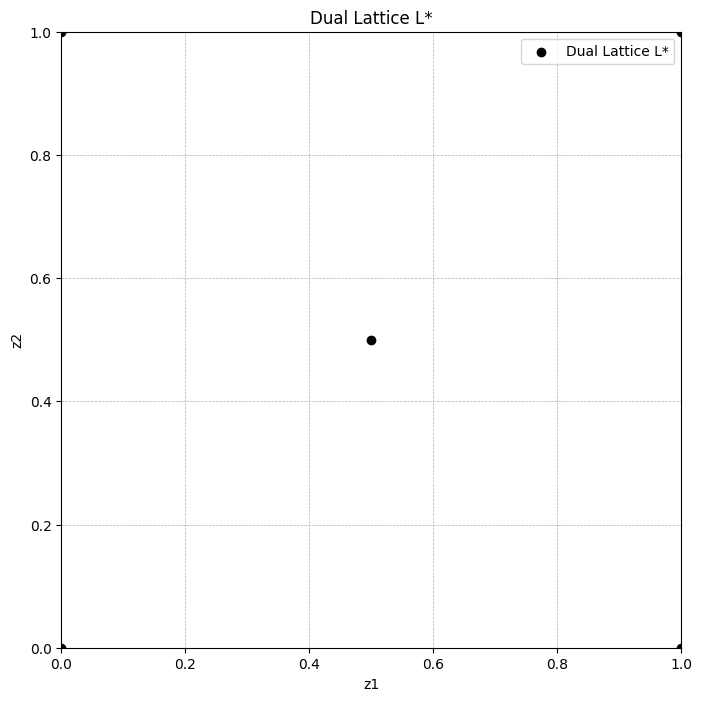

In [7]:
if __name__ == "__main__":
    N = 15
    b1 = 2
    b2 = 7
    result = find_lattices(N, b1, b2, z_range=10)

    print("Basis of the lattice L:")
    for vec in result["basis_L"]:
        print(vec)

    print("\nNon trivial factor of N:")
    print(result["factors"])

    dual_basis = compute_dual_lattice_from_basis(result["basis_L"])
    if dual_basis is not None:
        print("\nBasis of the dual lattice of L:")
        print(dual_basis)


    plot_lattices(result["L"], result["L0"])

    plot_dual_lattice(dual_basis, xlim=(0,1), ylim=(0,1), fig_name="expected_15_2_7")

## N=21, b_i=2,5

Basis of the lattice L:
[ 1 -1]
[-2 -1]

Non trivial factor of N:
[3, 7]

Basis of the dual lattice of L:
[[ 0.33333333 -0.33333333]
 [-0.66666667 -0.33333333]]


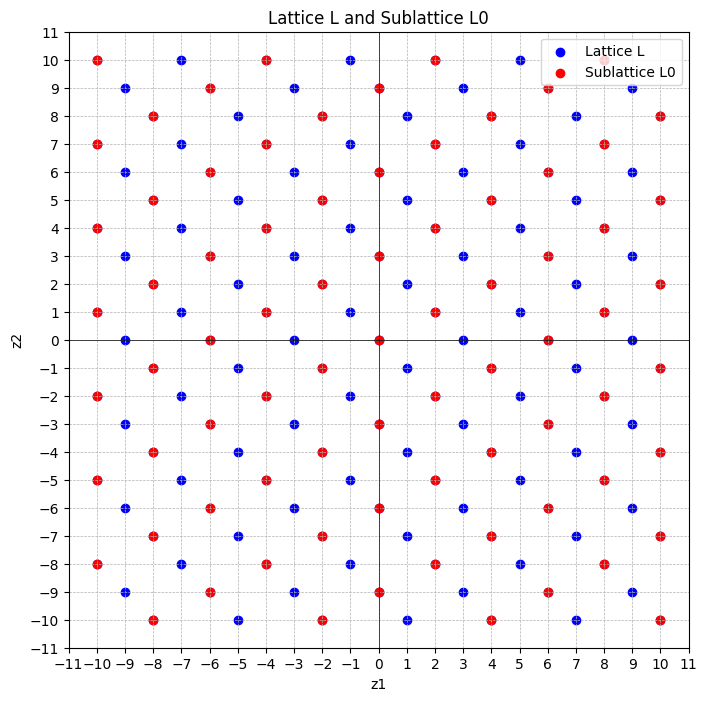

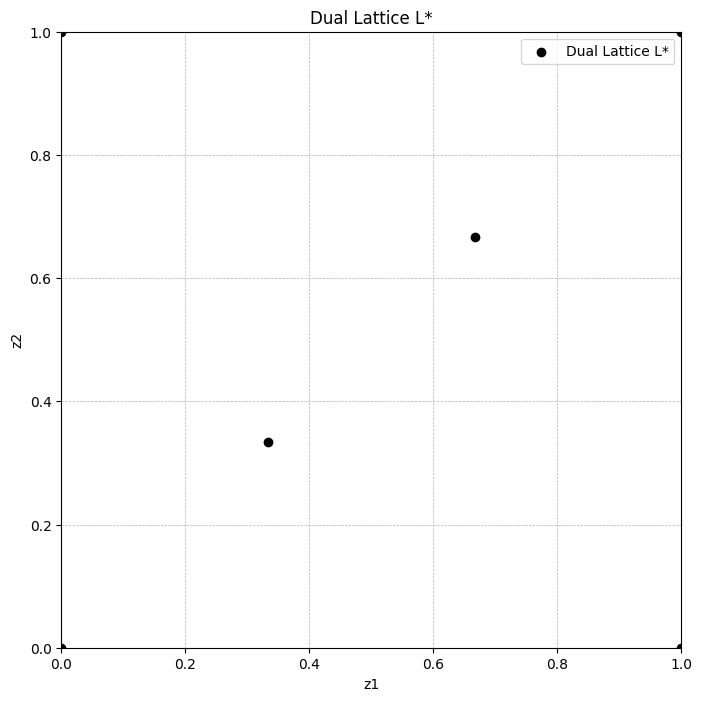

In [8]:
if __name__ == "__main__":
    N = 21
    b1 = 2
    b2 = 5
    result = find_lattices(N, b1, b2, z_range=10)

    print("Basis of the lattice L:")
    for vec in result["basis_L"]:
        print(vec)

    print("\nNon trivial factor of N:")
    print(result["factors"])

    dual_basis = compute_dual_lattice_from_basis(result["basis_L"])
    if dual_basis is not None:
        print("\nBasis of the dual lattice of L:")
        print(dual_basis)


    plot_lattices(result["L"], result["L0"])

    plot_dual_lattice(dual_basis, xlim=(0,1), ylim=(0,1), fig_name="expected_15_2_7")

Basis of the lattice L:
[-1 -1]
[-1  2]

Non trivial factor of N:
[]

Basis of the dual lattice of L:
[[-0.66666667 -0.33333333]
 [-0.33333333  0.33333333]]


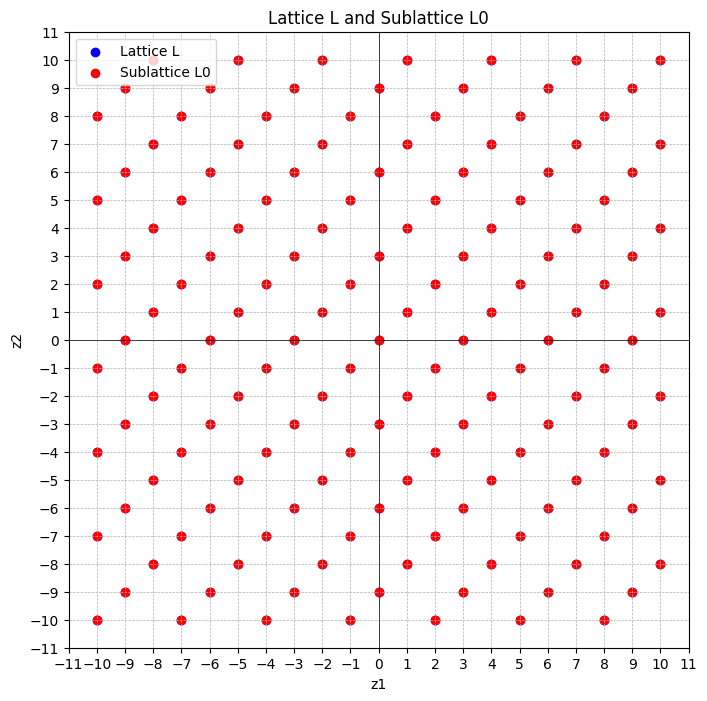

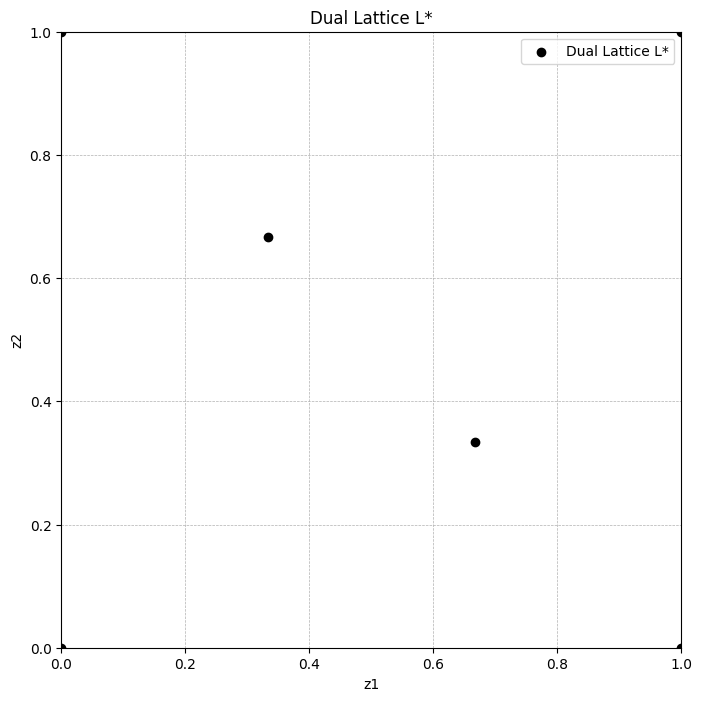

In [9]:
if __name__ == "__main__":
    N = 14
    b1 = 3
    b2 = 5
    result = find_lattices(N, b1, b2, z_range=10)

    print("Basis of the lattice L:")
    for vec in result["basis_L"]:
        print(vec)

    print("\nNon trivial factor of N:")
    print(result["factors"])

    dual_basis = compute_dual_lattice_from_basis(result["basis_L"])
    if dual_basis is not None:
        print("\nBasis of the dual lattice of L:")
        print(dual_basis)


    plot_lattices(result["L"], result["L0"])

    plot_dual_lattice(dual_basis, xlim=(0,1), ylim=(0,1), fig_name="expected_15_2_7")